In [22]:
# libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

DATA_PATH = "toyota"

try:
    df = pd.read_csv("D:\\data science\\Assignments\\Basic stats - 1\\Multiple Linear Regression\\ToyotaCorolla - MLR.csv")
    print("File loaded successfully")
except Exception as e:
    raise FileNotFoundError(f"Could not read {DATA_PATH}. Error: {e}")

    # Summary statistics
print('\n--- Summary statistics (numerical) ---')
display(df.describe(include='all'))


# Missing values
print('\n--- Missing values per column ---')
print(df.isnull().sum())


File loaded successfully

--- Summary statistics (numerical) ---


,Price,Age_08_04,KM,Fuel_Type,HP,Automatic,cc,Doors,Cylinders,Gears,Weight
count,1436.000000,1436.000000,1436.000000,1436,1436.000000,1436.000000,1436.00000,1436.000000,1436.0,1436.000000,1436.00000
unique,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,Petrol,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,1264,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,10730.824513,55.947075,68533.259749,NaN,101.502089,0.055710,1576.85585,4.033426,4.0,5.026462,1072.45961
std,3626.964585,18.599988,37506.448872,NaN,14.981080,0.229441,424.38677,0.952677,0.0,0.188510,52.64112
min,4350.000000,1.000000,1.000000,NaN,69.000000,0.000000,1300.00000,2.000000,4.0,3.000000,1000.00000
25%,8450.000000,44.000000,43000.000000,NaN,90.000000,0.000000,1400.00000,3.000000,4.0,5.000000,1040.00000
50%,9900.000000,61.000000,63389.500000,NaN,110.000000,0.000000,1600.00000,4.000000,4.0,5.000000,1070.00000
75%,11950.000000,70.000000,87020.750000,NaN,110.000000,0.000000,1600.00000,5.000000,4.0,5.000000,1085.00000



--- Missing values per column ---
Price        0
Age_08_04    0
KM           0
Fuel_Type    0
HP           0
Automatic    0
cc           0
Doors        0
Cylinders    0
Gears        0
Weight       0
dtype: int64


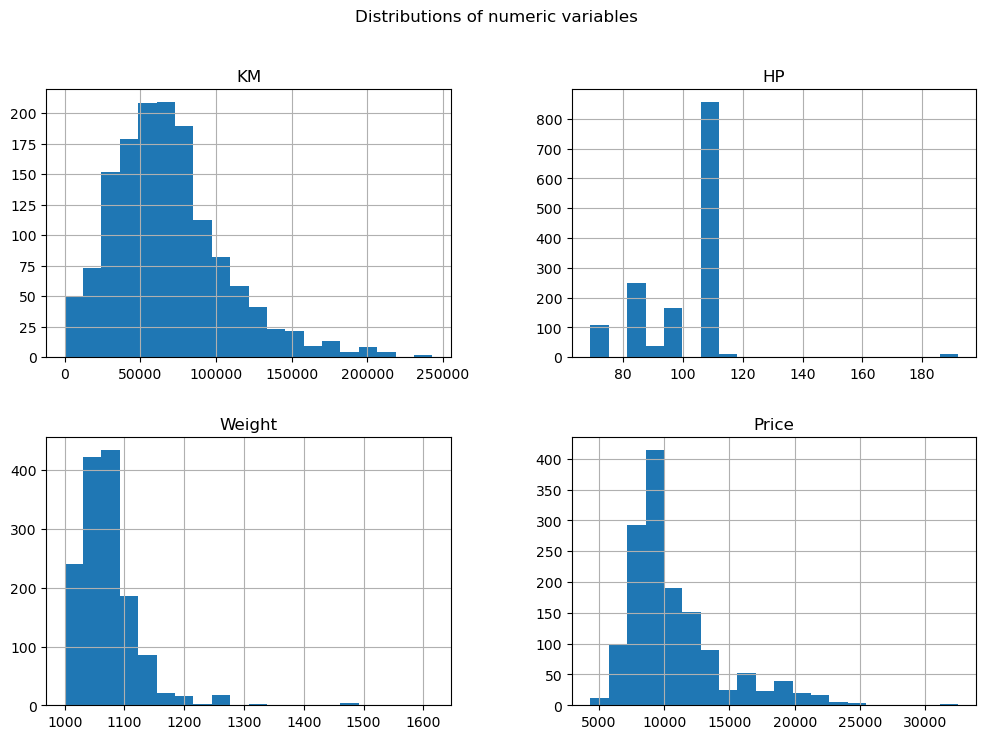

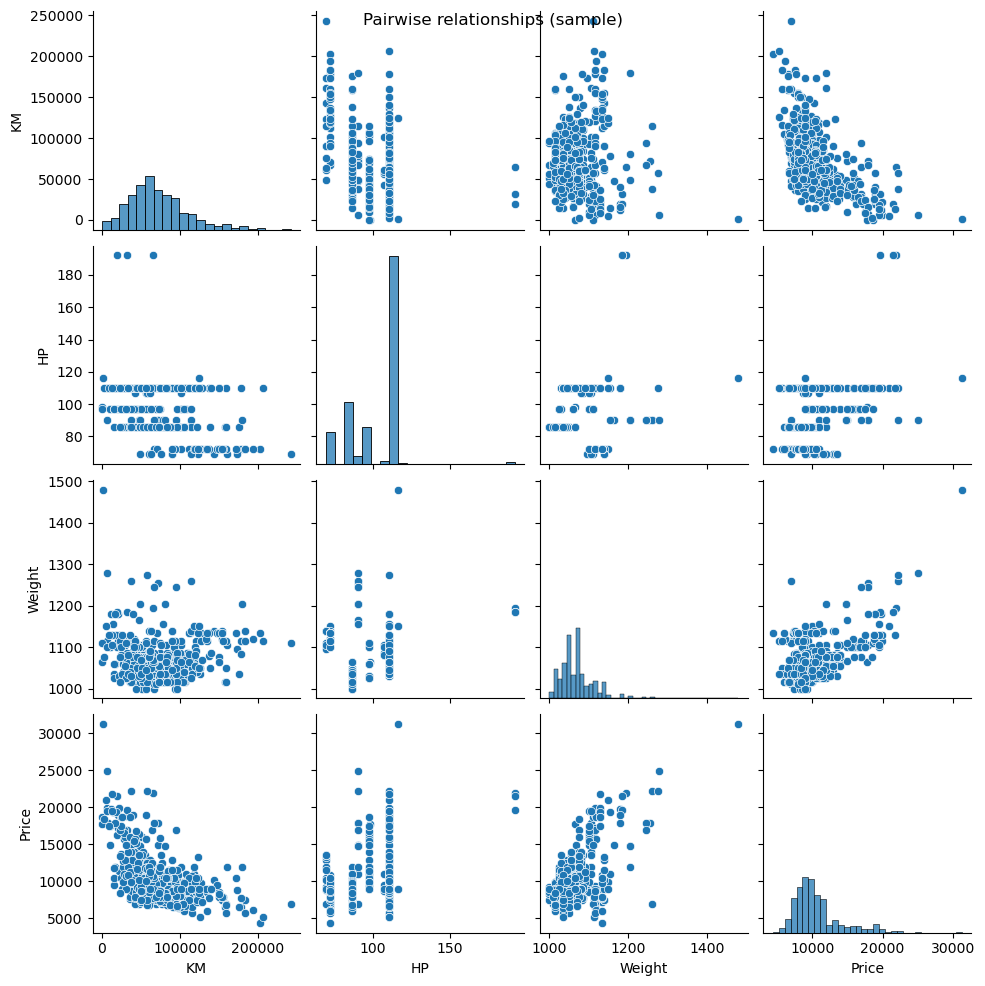

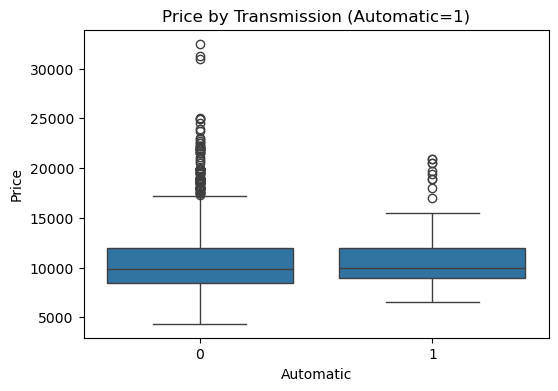

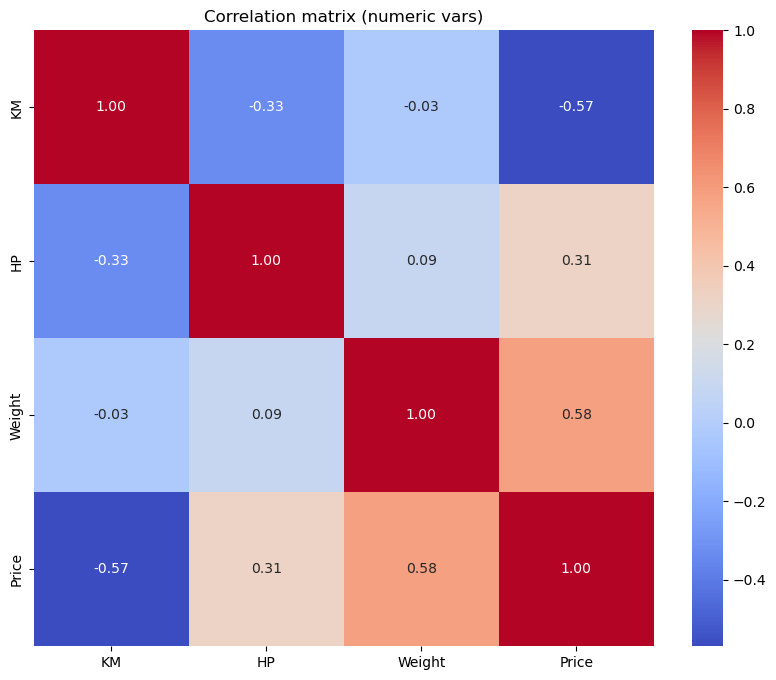

In [23]:

# Visualizations: distribution of Price and numeric features
numeric_cols = ['Age', 'KM', 'HP', 'CC', 'Quarterly_Tax', 'Weight', 'Price']
# only keep those that exist in dataset (defensive)
numeric_cols = [c for c in numeric_cols if c in df.columns]



# Histograms
df[numeric_cols].hist(bins=20, figsize=(12,8))
plt.suptitle('Distributions of numeric variables')
plt.show()
 

# Pairplot (sample if dataset is large)
sample = df[numeric_cols].sample(n=min(500, len(df)), random_state=1)
sns.pairplot(sample)
plt.suptitle('Pairwise relationships (sample)')
plt.show()


# Boxplot of Price by FuelType and Automatic
if 'FuelType' in df.columns:
 plt.figure(figsize=(8,5))
 sns.boxplot(x='FuelType', y='Price', data=df)
 plt.title('Price by Fuel Type')
 plt.show()


if 'Automatic' in df.columns:
 plt.figure(figsize=(6,4))
 sns.boxplot(x='Automatic', y='Price', data=df)
 plt.title('Price by Transmission (Automatic=1)')
 plt.show()


# Correlation heatmap
plt.figure(figsize=(10,8))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation matrix (numeric vars)')
plt.show()

# %% [markdown]
# 3. Preprocessing
# - Handle missing values
# - Encode categorical variables (FuelType)
# - Ensure numeric types
# - Optionally transform skewed variables (log)



In [24]:
# Copy dataset for processing
data = df.copy()

# Standardize column names (strip spaces)
data.columns = [c.strip() for c in data.columns]

# Check and handle missing values: For a general pipeline we'll drop rows with missing target
if data['Price'].isnull().any():
    data = data.dropna(subset=['Price'])

# For simplicity, fill numeric missing with median and categorical with mode.
num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove target from num_cols if present
if 'Price' in num_cols:
    num_cols.remove('Price')

# Fill numeric missing values
for c in num_cols:
    if data[c].isnull().any():
        data[c] = data[c].fillna(data[c].median())

# Fill categorical missing values
for c in cat_cols:
    if data[c].isnull().any():
        data[c] = data[c].fillna(data[c].mode().iloc[0])

print('\nAfter simple imputation, missing values:')
print(data.isnull().sum())

# Convert Automatic to numeric if needed
if 'Automatic' in data.columns and data['Automatic'].dtype not in ['int64', 'float64']:
    data['Automatic'] = data['Automatic'].replace({'Yes':1,'No':0,'Y':1,'N':0})
    data['Automatic'] = pd.to_numeric(data['Automatic'], errors='coerce').fillna(0).astype(int)

# Convert Doors to numeric if possible
if 'Doors' in data.columns:
    try:
        data['Doors'] = pd.to_numeric(data['Doors'], errors='coerce').fillna(data['Doors'].median()).astype(int)
    except Exception:
        pass
print('\nColumn dtypes:')
print(data.dtypes)



After simple imputation, missing values:
Price        0
Age_08_04    0
KM           0
Fuel_Type    0
HP           0
Automatic    0
cc           0
Doors        0
Cylinders    0
Gears        0
Weight       0
dtype: int64

Column dtypes:
Price         int64
Age_08_04     int64
KM            int64
Fuel_Type    object
HP            int64
Automatic     int64
cc            int64
Doors         int64
Cylinders     int64
Gears         int64
Weight        int64
dtype: object


In [27]:
X = data.drop(columns=['Price'])
y = data['Price']

# Identify which columns to use (limit to known variables list if present)
expected_cols = ['Age', 'KM', 'FuelType', 'HP', 'Automatic', 'CC', 'Doors', 'Weight', 'Quarterly_Tax']
use_cols = [c for c in expected_cols if c in X.columns]

print('\nUsing columns:', use_cols)
X = X[use_cols]

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

# Build preprocessing pipeline
# - One-hot encode FuelType
# - Scale numeric features (StandardScaler)
numeric_features = [c for c in use_cols if c not in ['FuelType']]
categorical_features = [c for c in use_cols if c in ['FuelType']]

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', cat_transformer, categorical_features)
])

# Helper function to assemble pipeline and return fitted model and predictions
def fit_and_eval(model, X_train, y_train, X_test, y_test, preprocessor):
    pipe = Pipeline(steps=[('pre', preprocessor), ('model', model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    return pipe, preds, {'RMSE': rmse, 'MAE': mae, 'R2': r2}



Using columns: ['KM', 'HP', 'Automatic', 'Doors', 'Weight']
Train shape: (1148, 5) Test shape: (288, 5)


In [29]:
# 6. Model 1: Baseline Linear Regression (all features)


def fit_and_eval(model, X_train, y_train, X_test, y_test, preprocessor):
    pipe = Pipeline(steps=[
        ('prep', preprocessor),
        ('model', model)
    ])

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

  
    rmse = mean_squared_error(y_test, preds) ** 0.5
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    metrics = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
    return pipe, preds, metrics



lr = LinearRegression()
pipe_lr, preds_lr, metrics_lr = fit_and_eval(lr, X_train, y_train, X_test, y_test, preprocessor)
print('Baseline Linear Regression metrics:', metrics_lr)

# Inspect coefficients (map back to feature names)
preprocessor.fit(X_train)

# numeric feature names
num_feat_names = numeric_features

# categorical names from onehot
if categorical_features:
    cat_ohe = preprocessor.named_transformers_['cat']['onehot']
    cat_names = list(cat_ohe.get_feature_names_out(categorical_features))
else:
    cat_names = []

feature_names = num_feat_names + cat_names

# coefficients
coefs = pipe_lr.named_steps['model'].coef_
coef_table = pd.DataFrame({'feature': feature_names, 'coefficient': coefs})

print('\nCoefficients (Model 1)')
display(coef_table.sort_values(by='coefficient', ascending=False))


Baseline Linear Regression metrics: {'RMSE': 2283.4916842659604, 'MAE': 1573.912161723027, 'R2': 0.6092020691331612}

Coefficients (Model 1)


,feature,coefficient
4,Weight,2088.212036
1,HP,309.619976
3,Doors,-45.233608
2,Automatic,-174.823546
0,KM,-1943.761167


In [30]:
# 7. Model 2: Linear Regression with Polynomial Features (interactions / squares)
# We'll add degree=2 polynomial features for numeric variables only (to capture non-linearities).


# %%
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly_num_transformer = Pipeline(steps=[('poly', poly), ('scaler', StandardScaler())])
preprocessor_poly = ColumnTransformer(transformers=[
('poly_num', poly_num_transformer, numeric_features),
('cat', cat_transformer, categorical_features)
])


lr2 = LinearRegression()
pipe_lr2, preds_lr2, metrics_lr2 = fit_and_eval(lr2, X_train, y_train, X_test, y_test, preprocessor_poly)
print('Polynomial (degree2) Linear Regression metrics:', metrics_lr2)

Polynomial (degree2) Linear Regression metrics: {'RMSE': 1804.2889414858062, 'MAE': 1325.397254600959, 'R2': 0.7560136323445865}


In [32]:
# 8. Model 3: Feature-selected OLS using statsmodels (backward selection by p-value)
# - We'll fit a full OLS after preprocessing (one-hot encoding) and then iteratively remove the highest p-value > 0.05

# %%

# Preprocess training data
X_train_pre = pd.DataFrame(
    preprocessor.transform(X_train),
    columns=(
        numeric_features +
        (list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features))
         if categorical_features else [])
    )
)

# Reset index to match y_train
X_train_pre = X_train_pre.reset_index(drop=True)
y_train_reset = y_train.reset_index(drop=True)

# Add constant for intercept
X_train_pre = sm.add_constant(X_train_pre)

# Fit full OLS
ols_model = sm.OLS(y_train_reset, X_train_pre).fit()
print(ols_model.summary())


# Backward Elimination Function
def backward_elimination(X, y, sl=0.05):
    X_be = X.copy()
    while True:
        model = sm.OLS(y, X_be).fit()
        pvalues = model.pvalues.drop('const', errors='ignore')

        if pvalues.empty:
            break

        max_p = pvalues.max()

        if max_p > sl:
            remove_col = pvalues.idxmax()
            X_be = X_be.drop(columns=[remove_col])
        else:
            break

    return model, X_be


# Run backward elimination
model_be, X_train_be = backward_elimination(X_train_pre, y_train_reset)

print("\nBackward-Eliminated Model Summary:")
print(model_be.summary())


# Prepare Test Data
X_test_pre = pd.DataFrame(
    preprocessor.transform(X_test),
    columns=(
        numeric_features +
        (list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features))
         if categorical_features else [])
    )
)

# Reset index to match shape logic
X_test_pre = X_test_pre.reset_index(drop=True)
X_test_pre = sm.add_constant(X_test_pre)

# Keep only columns selected in backward elimination
X_test_be = X_test_pre[X_train_be.columns]

# Predict
preds_be = model_be.predict(X_test_be)

# Metrics (fixed RMSE)
metrics_be = {
    'RMSE': (mean_squared_error(y_test, preds_be) ** 0.5),
    'MAE': mean_absolute_error(y_test, preds_be),
    'R2': r2_score(y_test, preds_be)
}

print("\nBackward Selection OLS metrics:", metrics_be)


                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     450.0
Date:                Wed, 05 Nov 2025   Prob (F-statistic):          5.84e-267
Time:                        07:39:45   Log-Likelihood:                -10411.
No. Observations:                1148   AIC:                         2.083e+04
Df Residuals:                    1142   BIC:                         2.086e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.075e+04     62.128    173.101      0.0

In [34]:
# 9. Regularization: Ridge and Lasso
# We'll use cross-validation to pick the best alpha

# Ridge with CV
alphas = np.logspace(-3, 3, 50)
ridge_cv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=5)
pipe_ridge = Pipeline(steps=[('pre', preprocessor), ('model', ridge_cv)])
pipe_ridge.fit(X_train, y_train)

best_alpha_ridge = pipe_ridge.named_steps['model'].alpha_
print('Best alpha for Ridge:', best_alpha_ridge)

preds_ridge = pipe_ridge.predict(X_test)

#  manual RMSE (old sklearn fix)
metrics_ridge = {
    'RMSE': mean_squared_error(y_test, preds_ridge) ** 0.5,
    'MAE': mean_absolute_error(y_test, preds_ridge),
    'R2': r2_score(y_test, preds_ridge)
}
print('Ridge metrics:', metrics_ridge)


# Lasso with CV
lasso_cv = LassoCV(alphas=None, cv=5, max_iter=5000, random_state=42)
pipe_lasso = Pipeline(steps=[('pre', preprocessor), ('model', lasso_cv)])
pipe_lasso.fit(X_train, y_train)

best_alpha_lasso = pipe_lasso.named_steps['model'].alpha_
print('Best alpha for Lasso:', best_alpha_lasso)

preds_lasso = pipe_lasso.predict(X_test)

#  manual RMSE (old sklearn fix)
metrics_lasso = {
    'RMSE': mean_squared_error(y_test, preds_lasso) ** 0.5,
    'MAE': mean_absolute_error(y_test, preds_lasso),
    'R2': r2_score(y_test, preds_lasso)
}
print('Lasso metrics:', metrics_lasso)


#  Build feature names again (to match pipeline output)
num_feat_names = numeric_features
cat_names = (
    list(preprocessor.named_transformers_['cat']['onehot']
         .get_feature_names_out(categorical_features))
    if categorical_features else []
)
feature_names_full = num_feat_names + cat_names

# Lasso coefficients
coef_lasso = pipe_lasso.named_steps['model'].coef_
coef_df = pd.DataFrame({'feature': feature_names_full, 'coefficient': coef_lasso})

print('\nLasso coefficients (non-zero)')
display(coef_df[coef_df['coefficient'].abs() > 1e-6]
        .sort_values(by='coefficient', ascending=False))


Best alpha for Ridge: 10.985411419875572
Ridge metrics: {'RMSE': 2277.8732341385194, 'MAE': 1575.8825650189158, 'R2': 0.6111227921249826}
Best alpha for Lasso: 2.1058183598031364
Lasso metrics: {'RMSE': 2282.8896350161203, 'MAE': 1574.2094320209437, 'R2': 0.6094081119987091}

Lasso coefficients (non-zero)


,feature,coefficient
4,Weight,2085.175555
1,HP,308.049522
3,Doors,-42.059114
2,Automatic,-172.293574
0,KM,-1941.946344


In [35]:
# 10. Compare metrics for all models


# %%
results = pd.DataFrame({
'Model': ['LinearRegression', 'PolyDeg2_LinearRegression', 'Backward_OLS', 'RidgeCV', 'LassoCV'],
'RMSE': [metrics_lr['RMSE'], metrics_lr2['RMSE'], metrics_be['RMSE'], metrics_ridge['RMSE'], metrics_lasso['RMSE']],
'MAE': [metrics_lr['MAE'], metrics_lr2['MAE'], metrics_be['MAE'], metrics_ridge['MAE'], metrics_lasso['MAE']],
'R2': [metrics_lr['R2'], metrics_lr2['R2'], metrics_be['R2'], metrics_ridge['R2'], metrics_lasso['R2']]
})


results

,Model,RMSE,MAE,R2
0,LinearRegression,2283.491684,1573.912162,0.609202
1,PolyDeg2_LinearRegression,1804.288941,1325.397255,0.756014
2,Backward_OLS,2284.564516,1577.594045,0.608835
3,RidgeCV,2277.873234,1575.882565,0.611123
4,LassoCV,2282.889635,1574.209432,0.609408



Interpretation (Model 1 — baseline linear regression):
Feature: Weight               Coef: 2088.2120
Feature: HP                   Coef: 309.6200
Feature: Doors                Coef: -45.2336
Feature: Automatic            Coef: -174.8235
Feature: KM                   Coef: -1943.7612

Key assumptions of linear regression (and notes on their validation):
1. Linearity: relationship between predictors and target is linear. We explored polynomial model to capture non-linearity.
2. Independence: observations assumed independent (important if data contains repeated entries or grouped samples).
3. Homoscedasticity: constant variance of residuals. Check residual plots for heteroscedasticity.
4. Normality of residuals: affects inference (p-values). Use Q-Q plot to inspect.
5. No perfect multicollinearity: check VIF if needed. High correlation seen between some numeric vars may warrant attention.


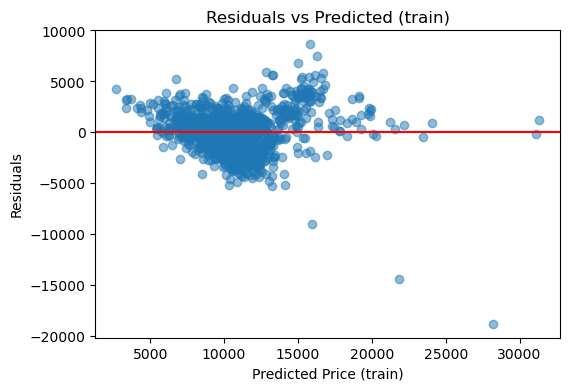

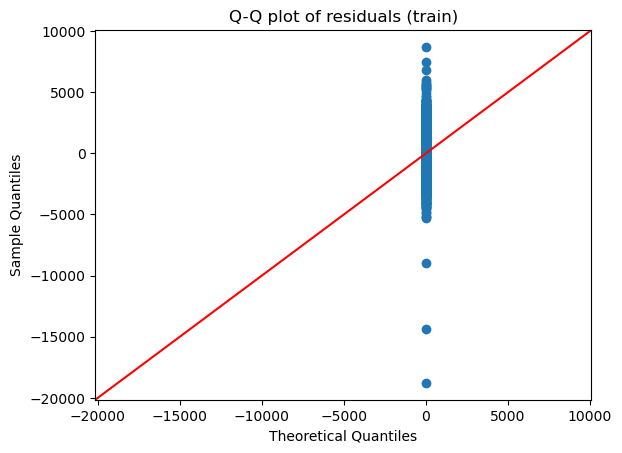

In [37]:
# 11. Interpretation and assumptions
# - Print short interpretation of coefficients for baseline linear model and discuss assumptions.


# %%
print('\nInterpretation (Model 1 — baseline linear regression):')
for _, row in coef_table.sort_values(by='coefficient', ascending=False).iterrows():
    print(f"Feature: {row['feature']:20} Coef: {row['coefficient']:.4f}")

print('\nKey assumptions of linear regression (and notes on their validation):')
print("1. Linearity: relationship between predictors and target is linear. We explored polynomial model to capture non-linearity.")
print("2. Independence: observations assumed independent (important if data contains repeated entries or grouped samples).")
print("3. Homoscedasticity: constant variance of residuals. Check residual plots for heteroscedasticity.")
print("4. Normality of residuals: affects inference (p-values). Use Q-Q plot to inspect.")
print("5. No perfect multicollinearity: check VIF if needed. High correlation seen between some numeric vars may warrant attention.")

# Residual diagnostics for baseline model
preds_train_lr = pipe_lr.predict(X_train)
residuals = y_train - preds_train_lr

plt.figure(figsize=(6,4))
plt.scatter(preds_train_lr, residuals, alpha=0.5)
plt.axhline(0, color='red')
plt.xlabel('Predicted Price (train)')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted (train)')
plt.show()

sm.qqplot(residuals, line='45')
plt.title('Q-Q plot of residuals (train)')
plt.show()


In [ ]:
# . Assumptions made during analysis
 
# -The dataset file is named `ToyotaCorolla.csv` in the working directory. Change `DATA_PATH` otherwise.
# - Simple median imputation was used for numeric columns and mode for categoricals if missing. For production,
# better imputation or domain knowledge would be applied.
# - Automatic was coerced to numeric using common mappings (Yes/No -> 1/0). Verify this mapping matches your data.
# - We limited categorical encoding to `FuelType` and used `drop='first'` to avoid multicollinearity.
# - Polynomial features were applied to numeric columns only and degree was set to 2. This can increase multicollinearity.
# - Models were evaluated on a single random 80/20 split with `random_state=42`. Consider k-fold CV for more robust estimates.
# - Check VIF for multicollinearity and consider dropping or combining highly correlated predictors.
# - Use k-fold cross-validation or repeated CV to get reliable performance estimates.
# - Consider log-transforming Price (and/or KM) if distribution is skewed — that often stabilizes variance.
# - Explore tree-based models (RandomForest, XGBoost) if linear assumptions do not hold — they often perform well on tabular data.




In [ ]:
# Interview Questions
# 1.What is Normalization & Standardization and how is it helpful?
 
# Normalization and Standardization are data preprocessing techniques used in machine learning to scale numerical features so that models learn efficiently and perform better.


# 2.What techniques can be used to address multicollinearity in multiple linear regression?

# 1. Remove highly correlated predictors	Drop one of the variables that are strongly correlated (e.g., correlation > 0.8). Choose the one less important.
 # 2. Variance Inflation Factor (VIF)	Calculate VIF for each predictor and remove variables with VIF > 5 or 10.
# 3. Combine correlated variables	Create composite features or averages (e.g., similar financial metrics).
# 4. Principal Component Analysis (PCA)	Transform correlated predictors into uncorrelated principal components.
# 5. Ridge Regression (L2 regularization)	Shrinks coefficients and reduces impact of multicollinearity without removing variables.
# 6. Lasso Regression (L1 regularization)	Can eliminate less important correlated features by shrinking coefficients to zero.
# 7. Domain knowledge feature selection	Choose the variables most meaningful from a business or problem perspective.
# 8. Increase sample size (if possible)	More data can sometimes reduce the effect, but not always feasible